# Statistical Analysis of the OI Facial Morphology Study

In this notebook we will be running statistical tests on the data gathered from the facial annotation of the anteroposterior photographs of the BBDC 7701 OI patient to determine morphological patterns. We will be comparing subjects affected by types I, III, and IV as well as an unaffected group.

Outline:
1. Data preparation:
    - load libraries
    - load database
2. Assessment of the sample population:
    - Sex (Chi-squared)
    - Ages (ANOVA)
3. Statistical shape analysis:
    - ProcGPA (mean shape)
    - MED
    - Ratio 1, 2, 3
    - LFH
4. Statistical Testing:
    - ProcGPA (Goodall's F-test)
    - MED (ANOVA)
    - Ratio 1, 2, 3 (ANOVA)
    - LFH (ANOVA)
4. Regression analysis:
5. PCA classification of images (or shallow neural net):

## Data Preparation

Here we will load the R libraries necessary for the statistical analysis and read the data from csv.

In [2]:
library('shapes','foreach')
library('dplyr','ggplot2')
library('reshape2','plyr')
library('dplyr')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
raw_data <- read.csv("./facial_analysis_data.csv")
raw_data$Group <- as.factor(raw_data$Group)
raw_data$Gender <- as.factor(raw_data$Gender)

In [4]:
set.seed(100)
dplyr::sample_n(raw_data, 10)

,Group,File.No.,Age,Gender,Genetic
95,3,239,3.90,F,NA
79,1,249,10.50,F,NA
168,4,86,16.25,F,NA
18,1,189,42.00,F,NA
142,4,243,32.10,F,NA
146,4,213,6.70,M,NA
244,c,71,11.50,M,NA
111,3,137,15.30,F,NA
163,4,229,11.25,F,NA
51,1,205,21.75,F,NA


In [5]:
# Check that Group and Gender are categorical data
levels(raw_data$Group)
grouped_data <- group_by(raw_data, Group)
summarise(grouped_data, mean=mean(Age), sd=sd(Age))
levels(raw_data$Gender)
count(grouped_data, Gender)

[1] "1" "3" "4" "c"

Group,mean,sd
1,19.66739,13.975618
3,15.41429,8.378421
4,17.12368,8.377559
c,17.71128,7.678985


[1] "F" "M"

Group,Gender,n
1,F,46
1,M,42
3,F,19
3,M,9
4,F,31
4,M,26
c,F,65
c,M,68


## Sample Group Assessment

Let us verify that the samples do not have any statistically significant differences between each other in terms of age and sex. We will use anova testing for the age of the patients and the chi-squared test for the sex of the groups.

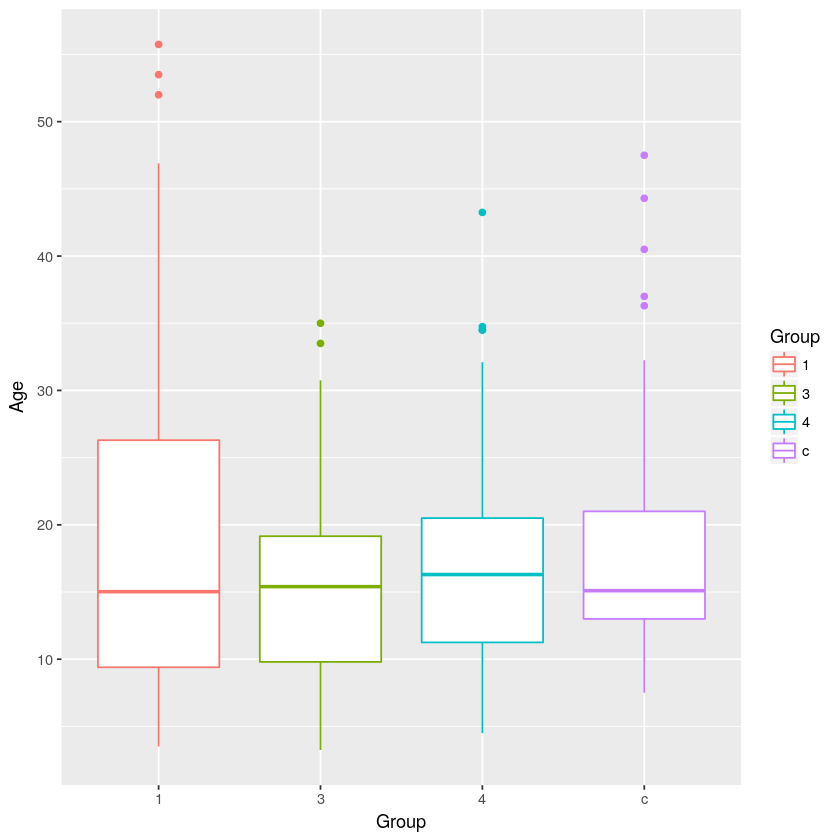

In [6]:
# Plot the group ages
ggplot2::ggplot(raw_data, ggplot2::aes(x=Group, y=Age, color=Group)) + ggplot2::geom_boxplot()

In [7]:
# Compute the analysis of variance on the age of the patients (ANOVA)
res.aov <- aov(Age ~ Group, data = raw_data)
# Summary of the analysis
summary(res.aov)

             Df Sum Sq Mean Sq F value Pr(>F)
Group         3    486   162.0   1.599   0.19
Residuals   302  30602   101.3               

In [8]:
# Compute the analysis of variance on the gender of the patients (Chi-Square)
chisq.test(raw_data$Group, raw_data$Gender, correct=FALSE)


	Pearson's Chi-squared test

data:  raw_data$Group and raw_data$Gender
X-squared = 3.4323, df = 3, p-value = 0.3296


**Neither the anova or chi-squared test showed statistically significant differences betweeen the groups. We can now commence our analysis.**

## Statistical Shape Analysis
1. Load data
2. Clean data
3. Create group matrices KxNxM
4. Compute mean shape per group
5. Compute mean euclidean distance per group
6. Compute facial ratios and lfh for each groups

### Load Data
We grab the landmark coordinates from csv file that was created by our image processing script

In [9]:
# lets now load our ladmark data
csv_data_file = './processed-dat//ldmk_coords.csv'
ldmk_data <- read.csv(csv_data_file, header = TRUE)
str(ldmk_data)
head(ldmk_data)

'data.frame':	68 obs. of  615 variables:
 $ X          : int  0 1 2 3 4 5 6 7 8 9 ...
 $ X.oi_t1.115: int  97 101 108 118 133 158 188 216 247 278 ...
 $ Y.oi_t1.115: int  309 350 389 426 460 486 506 524 531 526 ...
 $ X.oi_t1.135: int  97 103 111 121 134 156 187 223 260 297 ...
 $ Y.oi_t1.135: int  326 366 403 440 474 501 522 537 541 536 ...
 $ X.oi_t1.161: int  74 77 84 95 112 138 174 210 252 293 ...
 $ Y.oi_t1.161: int  349 393 436 478 517 549 573 593 598 591 ...
 $ X.oi_t1.131: int  110 116 123 129 141 163 193 225 261 297 ...
 $ Y.oi_t1.131: int  300 339 375 410 443 470 490 507 512 507 ...
 $ X.oi_t1.022: int  89 96 105 116 133 159 191 224 258 292 ...
 $ Y.oi_t1.022: int  369 412 453 493 530 562 588 613 620 614 ...
 $ X.oi_t1.004: int  94 94 97 102 112 133 163 201 244 286 ...
 $ Y.oi_t1.004: int  292 330 367 404 440 470 496 515 521 519 ...
 $ X.oi_t1.053: int  97 98 103 111 125 147 177 211 247 281 ...
 $ Y.oi_t1.053: int  343 380 415 450 483 512 536 554 561 555 ...
 $ X.oi_t1.158: i

X,X.oi_t1.115,Y.oi_t1.115,X.oi_t1.135,Y.oi_t1.135,X.oi_t1.161,Y.oi_t1.161,X.oi_t1.131,Y.oi_t1.131,X.oi_t1.022,⋯,X.ctl.90,Y.ctl.90,X.ctl.3,Y.ctl.3,X.ctl.62,Y.ctl.62,X.ctl.31,Y.ctl.31,X.ctl.51,Y.ctl.51
0,97,309,97,326,74,349,110,300,89,⋯,142,303,103,291,111,286,101,338,124,298
1,101,350,103,366,77,393,116,339,96,⋯,143,337,107,331,114,323,104,377,127,331
2,108,389,111,403,84,436,123,375,105,⋯,147,371,114,369,119,358,109,415,135,362
3,118,426,121,440,95,478,129,410,116,⋯,152,405,119,407,126,393,116,453,143,392
4,133,460,134,474,112,517,141,443,133,⋯,161,438,126,444,140,425,130,490,157,421
5,158,486,156,501,138,549,163,470,159,⋯,180,466,147,475,160,453,152,521,174,447


### Data Cleanup
Let's bind our landmark data to our current patient database

In [10]:
# this function takes as input a patient's group and file number and will fetch the X and Y coordinates of each
# landmark and bind them to our database
bind_to_patient <- function(inpt_db, ldmk_cols){
    matchno <- 0
    tmp_df_list <- list()
    
    for (i in rownames(inpt_db)){
        i <- as.integer(i)
        grp <- inpt_db[i,]$Group
        fln <- inpt_db[i,]$File.No.
        
        # find the matching group and create the appropriate label
        if (grp == 1){
            if (fln > 99){
                pt <- paste('oi_t1.',as.character(inpt_db[i,]$File.No.),sep='')
            }
            if (fln < 100 && fln > 9){
                pt <- paste('oi_t1.0',as.character(inpt_db[i,]$File.No.),sep='')
            }
            if (fln <10){
                pt <- paste('oi_t1.00',as.character(inpt_db[i,]$File.No.),sep='')
            }
        }

        if (grp == 3){
            if (fln > 99){
                pt <- paste('oi_t3.',as.character(inpt_db[i,]$File.No.),sep='')
            }
            if (fln < 100 && fln > 9){
                pt <- paste('oi_t3.0',as.character(inpt_db[i,]$File.No.),sep='')
            }
            if (fln <10){
                pt <- paste('oi_t3.00',as.character(inpt_db[i,]$File.No.),sep='')
            }
        }

        if (grp == 4){
            if (fln > 99){
                pt <- paste('oi_t4.',as.character(inpt_db[i,]$File.No.),sep='')
            }
            if (fln < 100 && fln > 9){
                pt <- paste('oi_t4.0',as.character(inpt_db[i,]$File.No.),sep='')
            }
            if (fln <10){
                pt <- paste('oi_t4.00',as.character(inpt_db[i,]$File.No.),sep='')
            }
        }

        if (as.character(grp) == 'c'){
            pt <- paste('ctl.',as.character(inpt_db[i,]$File.No.),sep='')
        
        }

        # begin by finding matching columns
        prelim_index_matches <- grep(pt, ldmk_cols)
    
        # grep with the ldmk data rownames and then verify to have only the results who are nchars + 2 to
        # avoid partial matches **** ie. 20 in 200
        index_matches <- c()
        for (id in prelim_index_matches){
            if (nchar(ldmk_cols[id]) == (nchar(pt) + 2)){
                index_matches <- c(index_matches, id)
            }
        }
        
        # skip forward if no matches ar found
        if (length(index_matches) == 0){
            print('[ERROR] No matches found')
            print(pt)
            next
        }
        
        # verify matches are accurate and that there are only 2 (x,y) [ie length=1]
        if (length(index_matches) != 2){
            print('[ERROR] Duplicate data in grep function') 
            next
        }

        matchno <- matchno + 1
        # create a 136 row array and bind it to the correct 
        a <- ldmk_data[index_matches[1]]
        b <- ldmk_data[index_matches[2]]
        a <- t(a)
        b <- t(b)
        c <- cbind(a,b)

        # create a new row for our database and append it to our list of dataframes
        new_row <- cbind(inpt_db[i,], c)
        x <- length(tmp_df_list)+1
        tmp_df_list[[x]] <- new_row

    }
    
    # concatenate our dataframes into our final output database
    outpt_db <- do.call("rbind", tmp_df_list)

    return(outpt_db)
}

ldmk_col_names <- colnames(ldmk_data)
full_db <- bind_to_patient(raw_data, ldmk_col_names)





In [11]:
head(full_db)

Group,File.No.,Age,Gender,Genetic,1,2,3,4,5,⋯,127,128,129,130,131,132,133,134,135,136
1,247,9.75,F,NA,115,122,131,140,153,⋯,453,451,444,436,437,437,447,439,440,438
1,248,46.00,M,NA,145,146,150,158,170,⋯,482,479,472,468,469,468,472,465,467,465
1,117,9.50,M,NA,110,116,123,130,144,⋯,518,514,505,504,504,504,506,503,504,504
1,118,4.50,F,NA,69,76,85,96,112,⋯,505,501,491,483,485,484,493,485,486,484
1,10,16.50,M,NA,123,125,129,135,149,⋯,436,430,420,419,421,420,423,420,421,419
1,145,32.00,F,NA,100,104,111,119,133,⋯,487,484,473,472,473,473,475,471,473,471


### Create Group Matrices

We will now create matrices of size KxMxN where K is the number of landmarks (68), M is the number of dimensions (2) and N is the number of samples.

In [12]:
# create a function to create matrices
make_matrix <- function(group_chr){
    subs_db <- subset(full_db, Group == group_chr)
    x_dat <- subs_db[,6:73]
    x_dat <- t(x_dat)
    y_dat <- subs_db[,74:141]
    y_dat <- t(y_dat)
    list_xy_dat <- list()

    for (i in (1:length(x_dat[1,]))){
        z <- length(list_xy_dat) + 1
        d <- cbind(x_dat[,i], y_dat[,i])
        d <- as.matrix(d)
        list_xy_dat[[z]] <- d
    }

    big_mat <- as.array(list_xy_dat)
    big_mat <- simplify2array(big_mat)
    return(big_mat)
}

oi1_mat <- make_matrix('1')
oi3_mat <- make_matrix('3')
oi4_mat <- make_matrix('4')
ctl_mat <- make_matrix('c')


### Compute Mean Shapes

In [16]:
oi1_gpa <- procGPA(oi1_mat, eigen2d=TRUE)
oi3_gpa <- procGPA(oi3_mat, eigen2d=TRUE)
oi4_gpa <- procGPA(oi4_mat, eigen2d=TRUE)
ctl_gpa <- procGPA(ctl_mat, eigen2d=TRUE)
list_grp_mat <- list(oi1_mat, oi3_mat, oi4_mat)

[1] "To speed up use option distances=FALSE"
[1] "To speed up use option pcaoutput=FALSE"


In [39]:
str(ctl_gpa$rotated)

 num [1:68, 1:2, 1:133] -0.0897 -0.0495 -0.0099 0.0308 0.072 ...


In [46]:
oi1_rmat <- matrix(oi1_gpa$rotated, 136, 88)
oi1_rmat <- t(oi1_rmat)
oi3_rmat <- matrix(oi3_gpa$rotated, 136, 28)
oi3_rmat <- t(oi3_rmat)
oi4_rmat <- matrix(oi4_gpa$rotated, 136, 57)
oi4_rmat <- t(oi4_rmat)
ctl_rmat <- matrix(ctl_gpa$rotated, 136, 133)
ctl_rmat <- t(ctl_rmat)
full_rmat <- rbind(oi1_rmat, oi3_rmat, oi4_rmat, ctl_rmat)
ml_db <- cbind(raw_data, full_rmat)
write.csv(ml_db, oi_ml_db.csv)

ERROR: Error in write.table(ml_db, oi_ml_db.csv, col.names = NA, sep = ",", dec = ".", : object 'oi_ml_db.csv' not found


### Compute Mean Euclidean Distance from Baseline Shape for each Group

In [54]:
# computes landmark distance from a predetermined baseline
compute_med <- function(input_mat){
    # we set our baseline shape to the mean shape of our control group
    base_shape <- ctl_gpa$mshape
    base_shape <- as.matrix(base_shape)
    len <- (1:(length(input_mat[1,,])/2))
    ed_vec <- c()
    
    # iterate through the matrices in the input
    for (i in len){
        mat <- as.matrix(input_mat[,,i])
        
        # let's gather our variables
        X1 <- mat[,1]
        X2 <- base_shape[,1]
        Y1 <- mat[,2]
        Y2 <- base_shape[,2]

        # simple euclidean arithmetic
        ed <-  sqrt((X2 - X1)**2 + (Y2-Y1)**2)
        ed_vec <- c(ed_vec, ed)
    }
    return(ed_vec)
}

# list of mean landmark distance per group
oi1_ed <- compute_med(oi1_gpa$rotated)
oi3_ed <- compute_med(oi3_gpa$rotated)
oi4_ed <- compute_med(oi4_gpa$rotated)

oi1_ed <- melt(data.frame(oi1_ed))
oi3_ed <- melt(data.frame(oi3_ed))
oi4_ed <- melt(data.frame(oi4_ed))
ed_df <- rbind(oi1_ed, oi3_ed, oi4_ed)

str(ed_df)
head(ed_df)

No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


'data.frame':	11764 obs. of  2 variables:
 $ variable: Factor w/ 3 levels "oi1_ed","oi3_ed",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ value   : num  0.0048 0.00845 0.00958 0.01012 0.01039 ...


variable,value
oi1_ed,0.004801372
oi1_ed,0.008445830
oi1_ed,0.009577129
oi1_ed,0.010120732
oi1_ed,0.010388364
oi1_ed,0.008815138


In [122]:
# lets visualize the euclidean distance per landmark group means

oi1_med <- compute_med(oi1_gpa$rotated)
oi3_med <- compute_med(oi3_gpa$rotated)
oi4_med <- compute_med(oi4_gpa$rotated)

oi1_med <- matrix(oi1_med, nrow=68)
oi3_med <- matrix(oi3_med, nrow=68)
oi4_med <- matrix(oi4_med, nrow=68)

oi1_med <- rowMeans(oi1_med)
oi3_med <- rowMeans(oi3_med)
oi4_med <- rowMeans(oi4_med)

med_df <- data.frame(oi1_med, oi3_med, oi4_med)
med_coln <- c('Type 1', 'Type 3', 'Type 4')
colnames(med_df) <- med_coln

png(filename="histo.png", res=720, width=16, height=9, units="in", pointsize=6)

barplot(
  as.matrix(t(med_df)),
  main='Mean Euclidean Distance of Each Landmark',
  names.arg=c(1:68),
  ylab='Distance',
  xlab='Landmark',
  beside=TRUE,
  col=colours,
  legend=colnames(med_df)
)
dev.off()

png 
  2

#### Compute Z-score MED

In [55]:
zscore <- (ed_df$value - mean(ed_df$value))/sd(ed_df$value)
ed_df <- cbind(ed_df, zscore)
head(ed_df)

variable,value,zscore
oi1_ed,0.004801372,-0.61760866
oi1_ed,0.008445830,0.04159964
oi1_ed,0.009577129,0.24622864
oi1_ed,0.010120732,0.34455546
oi1_ed,0.010388364,0.39296458
oi1_ed,0.008815138,0.10840003


### Compute the Facial Ratios and LFH

In [15]:
compute_ratio <- function(inpt_mat, pt1, pt2, pt3, pt4){
    
    
    # first we gather our coordinates
    X1 <- inpt_mat[pt1,1,]
    X2 <- inpt_mat[pt2,1,]
    X3 <- inpt_mat[pt3,1,]
    X4 <- inpt_mat[pt4,1,]
    
    Y1 <- inpt_mat[pt1,2,]
    Y2 <- inpt_mat[pt2,2,]
    Y3 <- inpt_mat[pt3,2,]
    Y4 <- inpt_mat[pt4,2,]
    
    # we compute the ratio
    ed12 <- sqrt((X2 - X1)**2 + (Y2-Y1)**2)
    ed34 <- sqrt((X3 - X4)**2 + (Y3-Y4)**2)
    ratio_vec <- ed12 / ed34
    
    return(ratio_vec)
}



# ratio 1: (biocular 37:46 / bitemporal 1:17)
oi1_ratio1 <- compute_ratio(oi1_mat, 37, 46, 1, 17)
oi3_ratio1 <- compute_ratio(oi3_mat, 37, 46, 1, 17)
oi4_ratio1 <- compute_ratio(oi4_mat, 37, 46, 1, 17)
ctl_ratio1 <- compute_ratio(ctl_mat, 37, 46, 1, 17)

oi1_ratio1 <- melt(data.frame(oi1_ratio1))
oi3_ratio1 <- melt(data.frame(oi3_ratio1))
oi4_ratio1 <- melt(data.frame(oi4_ratio1))
ctl_ratio1 <- melt(data.frame(ctl_ratio1))
ratio1_df <- rbind(ctl_ratio1, oi1_ratio1, oi3_ratio1, oi4_ratio1)
head(ratio1_df)

# ratio 2: (bimandibular 5:13 / bitemporal 1:17)
oi1_ratio2 <- compute_ratio(oi1_mat, 5, 13, 1, 17)
oi3_ratio2 <- compute_ratio(oi3_mat, 5, 13, 1, 17)
oi4_ratio2 <- compute_ratio(oi4_mat, 5, 13, 1, 17)
ctl_ratio2 <- compute_ratio(ctl_mat, 5, 13, 1, 17)

oi1_ratio2 <- melt(data.frame(oi1_ratio2))
oi3_ratio2 <- melt(data.frame(oi3_ratio2))
oi4_ratio2 <- melt(data.frame(oi4_ratio2))
ctl_ratio2 <- melt(data.frame(ctl_ratio2))
ratio2_df <- rbind(ctl_ratio2, oi1_ratio2, oi3_ratio2, oi4_ratio2)
head(ratio2_df)

# ratio 3: (bitemporal 1:17 / face height 28:9)
oi1_ratio3 <- compute_ratio(oi1_mat, 1, 17, 28, 9)
oi3_ratio3 <- compute_ratio(oi3_mat, 1, 17, 28, 9)
oi4_ratio3 <- compute_ratio(oi4_mat, 1, 17, 28, 9)
ctl_ratio3 <- compute_ratio(ctl_mat, 1, 17, 28, 9)

oi1_ratio3 <- melt(data.frame(oi1_ratio3))
oi3_ratio3 <- melt(data.frame(oi3_ratio3))
oi4_ratio3 <- melt(data.frame(oi4_ratio3))
ctl_ratio3 <- melt(data.frame(ctl_ratio3))
ratio3_df <- rbind(ctl_ratio3, oi1_ratio3, oi3_ratio3, oi4_ratio3)
head(ratio3_df)

# lfh: (lower face 34-9 / face height 28:9)
oi1_lfh <- compute_ratio(oi1_mat, 34, 9, 28, 9)
oi3_lfh <- compute_ratio(oi3_mat, 34, 9, 28, 9)
oi4_lfh <- compute_ratio(oi4_mat, 34, 9, 28, 9)
ctl_lfh <- compute_ratio(ctl_mat, 34, 9, 28, 9)

oi1_lfh <- melt(data.frame(oi1_lfh))
oi3_lfh <- melt(data.frame(oi3_lfh))
oi4_lfh <- melt(data.frame(oi4_lfh))
ctl_lfh <- melt(data.frame(ctl_lfh))
lfh_df <- rbind(ctl_lfh, oi1_lfh, oi3_lfh, oi4_lfh)
head(lfh_df)

No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


variable,value
ctl_ratio1,0.6246633
ctl_ratio1,0.6061659
ctl_ratio1,0.5993436
ctl_ratio1,0.6172652
ctl_ratio1,0.6026082
ctl_ratio1,0.5792949


No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


variable,value
ctl_ratio2,0.8267644
ctl_ratio2,0.7834141
ctl_ratio2,0.7948080
ctl_ratio2,0.8483678
ctl_ratio2,0.7878822
ctl_ratio2,0.7905491


No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


variable,value
ctl_ratio3,1.217263
ctl_ratio3,1.335484
ctl_ratio3,1.274087
ctl_ratio3,1.174030
ctl_ratio3,1.407767
ctl_ratio3,1.371741


No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


variable,value
ctl_lfh,0.5718910
ctl_lfh,0.5378159
ctl_lfh,0.5574577
ctl_lfh,0.5872246
ctl_lfh,0.5734729
ctl_lfh,0.5595804


##### Compute z-scores for facial ratios and lfh

In [57]:
# z-score ratio 1
zscore <- (ratio1_df$value - mean(ratio1_df$value))/sd(ratio1_df$value)
ratio1_df <- cbind(ratio1_df, zscore)
head(ratio1_df)

# z-score ratio 2
zscore <- (ratio2_df$value - mean(ratio2_df$value))/sd(ratio2_df$value)
ratio2_df <- cbind(ratio2_df, zscore)
head(ratio2_df)

# z-score ratio 3
zscore <- (ratio3_df$value - mean(ratio3_df$value))/sd(ratio3_df$value)
ratio3_df <- cbind(ratio3_df, zscore)
head(ratio3_df)

# z-score lfh
zscore <- (lfh_df$value - mean(lfh_df$value))/sd(lfh_df$value)
lfh_df <- cbind(lfh_df, zscore)
head(lfh_df)

variable,value,zscore
ctl_ratio1,0.6246633,0.69707397
ctl_ratio1,0.6061659,0.05065980
ctl_ratio1,0.5993436,-0.18775559
ctl_ratio1,0.6172652,0.43853844
ctl_ratio1,0.6026082,-0.07366979
ctl_ratio1,0.5792949,-0.88838254


variable,value,zscore
ctl_ratio2,0.8267644,1.10093363
ctl_ratio2,0.7834141,-0.23282326
ctl_ratio2,0.7948080,0.11773161
ctl_ratio2,0.8483678,1.76560412
ctl_ratio2,0.7878822,-0.09535257
ctl_ratio2,0.7905491,-0.01330282


variable,value,zscore
ctl_ratio3,1.217263,-0.8637688
ctl_ratio3,1.335484,0.2694227
ctl_ratio3,1.274087,-0.3190867
ctl_ratio3,1.174030,-1.2781698
ctl_ratio3,1.407767,0.9622831
ctl_ratio3,1.371741,0.6169639


variable,value,zscore
ctl_lfh,0.5718910,0.1340174
ctl_lfh,0.5378159,-1.2193521
ctl_lfh,0.5574577,-0.4392337
ctl_lfh,0.5872246,0.7430252
ctl_lfh,0.5734729,0.1968450
ctl_lfh,0.5595804,-0.3549243


## Statistical Testing

### Test Mean Shapes using Goodall's F test

In [66]:
res_ctl_oi1 <- testmeanshapes(ctl_mat, oi1_mat, resamples=400, replace=TRUE)
res_ctl_oi3 <- testmeanshapes(ctl_mat, oi3_mat, resamples=400, replace=TRUE)
res_ctl_oi4 <- testmeanshapes(ctl_mat, oi4_mat, resamples=400, replace=TRUE)
res_oi1_oi3 <- testmeanshapes(oi1_mat, oi3_mat, resamples=400, replace=TRUE)
res_oi1_oi4 <- testmeanshapes(oi1_mat, oi4_mat, resamples=400, replace=TRUE)
res_oi3_oi4 <- testmeanshapes(oi3_mat, oi4_mat, resamples=400, replace=TRUE)
print('[DONE]')

[1] "To speed up use option distances=FALSE"
*Bootstrap - sampling with replacement within each group under H0: No of resamples =  400 
*****************************************************************************************************************************************100  **********************************************************************************************************************************200  *******************************************************************************************************************************************300  *******************************************************************************************************************************400  * 
[1] "To speed up use option distances=FALSE"
*Bootstrap - sampling with replacement within each group under H0: No of resamples =  400 
****************************************************************************************************************************************************************************

In [67]:
print(paste('Control - Type 1: ', as.character(res_ctl_oi1$G.pvalue))) 
print(paste('Control - Type 3: ', as.character(res_ctl_oi3$G.pvalue))) 
print(paste('Control - Type 4: ', as.character(res_ctl_oi4$G.pvalue))) 
print(paste('Type 1 - Type 3: ', as.character(res_oi1_oi3$G.pvalue))) 
print(paste('Type 1 - Type 4: ', as.character(res_oi1_oi4$G.pvalue))) 
print(paste('Type 3 - Type 4: ', as.character(res_oi3_oi4$G.pvalue))) 

[1] "Control - Type 1:  0.00249376558603491"
[1] "Control - Type 3:  0.00249376558603491"
[1] "Control - Type 4:  0.00249376558603491"
[1] "Type 1 - Type 3:  0.00997506234413965"
[1] "Type 1 - Type 4:  0.1571072319202"
[1] "Type 3 - Type 4:  0.029925187032419"


### ANOVA Testing of the MED

In [133]:
aov.med.res <- aov(value ~ variable, data = ed_df)
print(paste('Type 1: ', as.character(mean(oi1_ed$value)), '+/-', as.character(sd(oi1_ed$value))))
print(paste('Type 3: ', as.character(mean(oi3_ed$value)), '+/-', as.character(sd(oi3_ed$value))))
print(paste('Type 4: ', as.character(mean(oi4_ed$value)), '+/-', as.character(sd(oi4_ed$value))))
summary(aov.med.res)
pairwise.t.test(ed_df$value, ed_df$variable, p.adj = "bonf")

[1] "Type 1:  0.00753903672547451 +/- 0.00501367908889013"
[1] "Type 3:  0.0106413755404304 +/- 0.00639639417365096"
[1] "Type 4:  0.00806925228057834 +/- 0.00550080891926833"


               Df Sum Sq  Mean Sq F value Pr(>F)    
variable        2 0.0140 0.007013   238.7 <2e-16 ***
Residuals   11761 0.3455 0.000029                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ed_df$value and ed_df$variable 

       oi1_ed  oi3_ed 
oi3_ed < 2e-16 -      
oi4_ed 6.3e-06 < 2e-16

P value adjustment method: bonferroni 

### ANOVA Testing of the MED Z-Score

In [66]:
aov.medz.res <- aov(zscore ~ variable, data = ed_df)
print(paste('Type 1: ', as.character(mean(ed_df[which(ed_df$variable=='oi1_ed'),]$zscore)), '+/-', as.character(sd(ed_df[which(ed_df$variable=='oi1_ed'),]$zscore))))
print(paste('Type 3: ', as.character(mean(ed_df[which(ed_df$variable=='oi3_ed'),]$zscore)), '+/-', as.character(sd(ed_df[which(ed_df$variable=='oi3_ed'),]$zscore))))
print(paste('Type 4: ', as.character(mean(ed_df[which(ed_df$variable=='oi4_ed'),]$zscore)), '+/-', as.character(sd(ed_df[which(ed_df$variable=='oi4_ed'),]$zscore))))
summary(aov.medz.res)
pairwise.t.test(ed_df$zscore, ed_df$variable, p.adj = "bonf")

[1] "Type 1:  -0.122420800015635 +/- 0.906872643846323"
[1] "Type 3:  0.438729236383863 +/- 1.15697769891095"
[1] "Type 4:  -0.0265155827609166 +/- 0.994984529218164"


               Df Sum Sq Mean Sq F value Pr(>F)    
variable        2    459  229.45   238.7 <2e-16 ***
Residuals   11761  11304    0.96                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ed_df$zscore and ed_df$variable 

       oi1_ed  oi3_ed 
oi3_ed < 2e-16 -      
oi4_ed 6.3e-06 < 2e-16

P value adjustment method: bonferroni 

### ANOVA Testing of Ratio 1

In [67]:
aov.ratio1.res <- aov(value ~ variable, data = ratio1_df) 
print(paste('Control: ', as.character(mean(ctl_ratio1$value)), '+/-', as.character(sd(ctl_ratio1$value))))
print(paste('Type 1: ', as.character(mean(oi1_ratio1$value)), '+/-', as.character(sd(oi1_ratio1$value))))
print(paste('Type 3: ', as.character(mean(oi3_ratio1$value)), '+/-', as.character(sd(oi3_ratio1$value))))
print(paste('Type 4: ', as.character(mean(oi4_ratio1$value)), '+/-', as.character(sd(oi4_ratio1$value))))
summary(aov.ratio1.res)
pairwise.t.test(ratio1_df$value, ratio1_df$variable, p.adj = "bonf")

[1] "Control:  0.611762229065928 +/- 0.0257822254413421"
[1] "Type 1:  0.595468819842491 +/- 0.0264859231020785"
[1] "Type 3:  0.604958978587533 +/- 0.0355451448263293"
[1] "Type 4:  0.602433399403848 +/- 0.0305984785308337"


             Df  Sum Sq  Mean Sq F value  Pr(>F)    
variable      3 0.01443 0.004809   6.172 0.00044 ***
Residuals   302 0.23532 0.000779                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ratio1_df$value and ratio1_df$variable 

           ctl_ratio1 oi1_ratio1 oi3_ratio1
oi1_ratio1 0.00017    -          -         
oi3_ratio1 1.00000    0.70912    -         
oi4_ratio1 0.21356    0.85976    1.00000   

P value adjustment method: bonferroni 

### ANOVA Testing of Ratio 1 Z-Score

In [71]:
aov.ratio1z.res <- aov(zscore ~ variable, data = ratio1_df)
print(paste('Control: ', as.character(mean(ratio1_df[which(ratio1_df$variable=='ctl_ratio1'),]$zscore)), '+/-', as.character(sd(ratio1_df[which(ratio1_df$variable=='ctl_ratio1'),]$zscore))))
print(paste('Type 1: ', as.character(mean(ratio1_df[which(ratio1_df$variable=='oi1_ratio1'),]$zscore)), '+/-', as.character(sd(ratio1_df[which(ratio1_df$variable=='oi1_ratio1'),]$zscore))))
print(paste('Type 3: ', as.character(mean(ratio1_df[which(ratio1_df$variable=='oi3_ratio1'),]$zscore)), '+/-', as.character(sd(ratio1_df[which(ratio1_df$variable=='oi3_ratio1'),]$zscore))))
print(paste('Type 4: ', as.character(mean(ratio1_df[which(ratio1_df$variable=='oi4_ratio1'),]$zscore)), '+/-', as.character(sd(ratio1_df[which(ratio1_df$variable=='oi4_ratio1'),]$zscore))))
summary(aov.ratio1z.res)
pairwise.t.test(ratio1_df$zscore, ratio1_df$variable, p.adj = "bonf")

[1] "Control:  0.246229077853313 +/- 0.900993108554223"
[1] "Type 1:  -0.323165114225665 +/- 0.925584730571949"
[1] "Type 3:  0.00848071859130702 +/- 1.24217091359889"
[1] "Type 4:  -0.0797789021612063 +/- 1.06930328226509"


             Df Sum Sq Mean Sq F value  Pr(>F)    
variable      3  17.62   5.873   6.172 0.00044 ***
Residuals   302 287.38   0.952                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ratio1_df$zscore and ratio1_df$variable 

           ctl_ratio1 oi1_ratio1 oi3_ratio1
oi1_ratio1 0.00017    -          -         
oi3_ratio1 1.00000    0.70912    -         
oi4_ratio1 0.21356    0.85976    1.00000   

P value adjustment method: bonferroni 

### ANOVA Testing of Ratio 2

In [135]:
aov.ratio2.res <- aov(value ~ variable, data = ratio2_df) 
print(paste('Control: ', as.character(mean(ctl_ratio2$value)), '+/-', as.character(sd(ctl_ratio2$value))))
print(paste('Type 1: ', as.character(mean(oi1_ratio2$value)), '+/-', as.character(sd(oi1_ratio2$value))))
print(paste('Type 3: ', as.character(mean(oi3_ratio2$value)), '+/-', as.character(sd(oi3_ratio2$value))))
print(paste('Type 4: ', as.character(mean(oi4_ratio2$value)), '+/-', as.character(sd(oi4_ratio2$value))))
summary(aov.ratio2.res)
pairwise.t.test(ratio2_df$value, ratio2_df$variable, p.adj = "bonf")

[1] "Control:  0.798996012424221 +/- 0.0271565466947241"
[1] "Type 1:  0.783984756426955 +/- 0.0381999989409837"
[1] "Type 3:  0.773518622222659 +/- 0.0296545154195152"
[1] "Type 4:  0.791660876479689 +/- 0.0306895681331188"


             Df  Sum Sq  Mean Sq F value   Pr(>F)    
variable      3 0.02142 0.007139   7.167 0.000116 ***
Residuals   302 0.30079 0.000996                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ratio2_df$value and ratio2_df$variable 

           ctl_ratio2 oi1_ratio2 oi3_ratio2
oi1_ratio2 0.00369    -          -         
oi3_ratio2 0.00076    0.76469    -         
oi4_ratio2 0.85864    0.92152    0.07965   

P value adjustment method: bonferroni 

### ANOVA Testing of Ratio 2 Z-Scores

In [72]:
aov.ratio2z.res <- aov(zscore ~ variable, data = ratio2_df)
print(paste('Control: ', as.character(mean(ratio2_df[which(ratio2_df$variable=='ctl_ratio2'),]$zscore)), '+/-', as.character(sd(ratio2_df[which(ratio2_df$variable=='ctl_ratio2'),]$zscore))))
print(paste('Type 1: ', as.character(mean(ratio2_df[which(ratio2_df$variable=='oi1_ratio2'),]$zscore)), '+/-', as.character(sd(ratio2_df[which(ratio2_df$variable=='oi1_ratio2'),]$zscore))))
print(paste('Type 3: ', as.character(mean(ratio2_df[which(ratio2_df$variable=='oi3_ratio2'),]$zscore)), '+/-', as.character(sd(ratio2_df[which(ratio2_df$variable=='oi3_ratio2'),]$zscore))))
print(paste('Type 4: ', as.character(mean(ratio2_df[which(ratio2_df$variable=='oi4_ratio2'),]$zscore)), '+/-', as.character(sd(ratio2_df[which(ratio2_df$variable=='oi4_ratio2'),]$zscore))))
summary(aov.ratio2z.res)
pairwise.t.test(ratio2_df$zscore, ratio2_df$variable, p.adj = "bonf")

[1] "Control:  0.24658407686873 +/- 0.835524192976292"
[1] "Type 1:  -0.215266529309889 +/- 1.17529756804687"
[1] "Type 3:  -0.537277587377325 +/- 0.912379079067776"
[1] "Type 4:  0.0209042947770848 +/- 0.944224497152162"


             Df Sum Sq Mean Sq F value   Pr(>F)    
variable      3  20.27   6.757   7.167 0.000116 ***
Residuals   302 284.73   0.943                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ratio2_df$zscore and ratio2_df$variable 

           ctl_ratio2 oi1_ratio2 oi3_ratio2
oi1_ratio2 0.00369    -          -         
oi3_ratio2 0.00076    0.76469    -         
oi4_ratio2 0.85864    0.92152    0.07965   

P value adjustment method: bonferroni 

### ANOVA Testing of Ratio 3

In [136]:
aov.ratio3.res <- aov(value ~ variable, data = ratio3_df)
print(paste('Control: ', as.character(mean(ctl_ratio3$value)), '+/-', as.character(sd(ctl_ratio3$value))))
print(paste('Type 1: ', as.character(mean(oi1_ratio3$value)), '+/-', as.character(sd(oi1_ratio3$value))))
print(paste('Type 3: ', as.character(mean(oi3_ratio3$value)), '+/-', as.character(sd(oi3_ratio3$value))))
print(paste('Type 4: ', as.character(mean(oi4_ratio3$value)), '+/-', as.character(sd(oi4_ratio3$value))))
summary(aov.ratio3.res)
pairwise.t.test(ratio3_df$value, ratio3_df$variable, p.adj = "bonf")

[1] "Control:  1.26108263737859 +/- 0.0757543223270305"
[1] "Type 1:  1.3349359861059 +/- 0.106371901538172"
[1] "Type 3:  1.40225598995642 +/- 0.124271923610922"
[1] "Type 4:  1.32623734753888 +/- 0.0978755302379388"


             Df Sum Sq Mean Sq F value   Pr(>F)    
variable      3 0.6242 0.20807   23.31 1.34e-13 ***
Residuals   302 2.6953 0.00892                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ratio3_df$value and ratio3_df$variable 

           ctl_ratio3 oi1_ratio3 oi3_ratio3
oi1_ratio3 1.8e-07    -          -         
oi3_ratio3 3.1e-11    0.00686    -         
oi4_ratio3 0.00011    1.00000    0.00337   

P value adjustment method: bonferroni 

### ANOVA Testing of Ratio 3 Z-Scores

In [73]:
aov.ratio3z.res <- aov(zscore ~ variable, data = ratio3_df)
print(paste('Control: ', as.character(mean(ratio3_df[which(ratio3_df$variable=='ctl_ratio3'),]$zscore)), '+/-', as.character(sd(ratio3_df[which(ratio3_df$variable=='ctl_ratio3'),]$zscore))))
print(paste('Type 1: ', as.character(mean(ratio3_df[which(ratio3_df$variable=='oi1_ratio3'),]$zscore)), '+/-', as.character(sd(ratio3_df[which(ratio3_df$variable=='oi1_ratio3'),]$zscore))))
print(paste('Type 3: ', as.character(mean(ratio3_df[which(ratio3_df$variable=='oi3_ratio3'),]$zscore)), '+/-', as.character(sd(ratio3_df[which(ratio3_df$variable=='oi3_ratio3'),]$zscore))))
print(paste('Type 4: ', as.character(mean(ratio3_df[which(ratio3_df$variable=='oi4_ratio3'),]$zscore)), '+/-', as.character(sd(ratio3_df[which(ratio3_df$variable=='oi4_ratio3'),]$zscore))))
summary(aov.ratio3z.res)
pairwise.t.test(ratio3_df$zscore, ratio3_df$variable, p.adj = "bonf")

[1] "Control:  -0.443739945552773 +/- 0.726134839297658"
[1] "Type 1:  0.264173317510796 +/- 1.0196163236173"
[1] "Type 3:  0.909461911955422 +/- 1.19119504351013"
[1] "Type 4:  0.180793461102052 +/- 0.938175278153593"


             Df Sum Sq Mean Sq F value   Pr(>F)    
variable      3  57.35   19.12   23.31 1.34e-13 ***
Residuals   302 247.65    0.82                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Pairwise comparisons using t tests with pooled SD 

data:  ratio3_df$zscore and ratio3_df$variable 

           ctl_ratio3 oi1_ratio3 oi3_ratio3
oi1_ratio3 1.8e-07    -          -         
oi3_ratio3 3.1e-11    0.00686    -         
oi4_ratio3 0.00011    1.00000    0.00337   

P value adjustment method: bonferroni 

### ANOVA Testing of the LFH

In [138]:
aov.lfh.res <- aov(value ~ variable, data = lfh_df)
print(paste('Control: ', as.character(mean(ctl_lfh$value)), '+/-', as.character(sd(ctl_lfh$value))))
print(paste('Type 1: ', as.character(mean(oi1_lfh$value)), '+/-', as.character(sd(oi1_lfh$value))))
print(paste('Type 3: ', as.character(mean(oi3_lfh$value)), '+/-', as.character(sd(oi3_lfh$value))))
print(paste('Type 4: ', as.character(mean(oi4_lfh$value)), '+/-', as.character(sd(oi4_lfh$value))))
summary(aov.lfh.res)

[1] "Control:  0.568981670340754 +/- 0.0219356406935681"
[1] "Type 1:  0.570576769894556 +/- 0.0256713125708904"
[1] "Type 3:  0.562142738613134 +/- 0.0354159597103009"
[1] "Type 4:  0.567382423404346 +/- 0.0257113348374836"


             Df  Sum Sq   Mean Sq F value Pr(>F)
variable      3 0.00161 0.0005377   0.847  0.469
Residuals   302 0.19174 0.0006349               

### ANOVA Testinf og the LFH Z-Scores

In [75]:
aov.lfhz.res <- aov(zscore ~ variable, data = lfh_df)
print(paste('Control: ', as.character(mean(lfh_df[which(lfh_df$variable=='ctl_lfh'),]$zscore)), '+/-', as.character(sd(lfh_df[which(lfh_df$variable=='ctl_lfh'),]$zscore))))
print(paste('Type 1: ', as.character(mean(lfh_df[which(lfh_df$variable=='oi1_lfh'),]$zscore)), '+/-', as.character(sd(lfh_df[which(lfh_df$variable=='oi1_lfh'),]$zscore))))
print(paste('Type 3: ', as.character(mean(lfh_df[which(lfh_df$variable=='oi3_lfh'),]$zscore)), '+/-', as.character(sd(lfh_df[which(lfh_df$variable=='oi3_lfh'),]$zscore))))
print(paste('Type 4: ', as.character(mean(lfh_df[which(lfh_df$variable=='oi4_lfh'),]$zscore)), '+/-', as.character(sd(lfh_df[which(lfh_df$variable=='oi4_lfh'),]$zscore))))
summary(aov.lfhz.res)

[1] "Control:  0.0184670454068222 +/- 0.871224711727987"
[1] "Type 1:  0.0818201139746197 +/- 1.01959556170206"
[1] "Type 3:  -0.253156947990851 +/- 1.40662676418767"
[1] "Type 4:  -0.0450507460549237 +/- 1.02118513859942"


             Df Sum Sq Mean Sq F value Pr(>F)
variable      3   2.54  0.8482   0.847  0.469
Residuals   302 302.46  1.0015               